#1. Introduction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. EDA

## Install and import necessary packages

In [ ]:
!pip install pyvi
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 3.5 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import re
import emoji
from wordcloud import WordCloud
from pyvi.ViTokenizer import ViTokenizer
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
DATA_PATH = "/content/drive/MyDrive/midtermdata/"

os.listdir(DATA_PATH)

['cc.vi.300.vec',
 'dev.csv',
 'test.csv',
 'train.csv',
 'facebook_comment_2k7.csv',
 'facebook_comment_2k7.gsheet',
 'train.gsheet',
 'vietnamese-stopwords-dash.txt',
 'VnCoreNLP-1.1.1.jar',
 'Text_CNN_model_v1.h5',
 'GRU_model_v1.h5',
 'transformer_model']

## Load data 2k7

Mục đích xây dựng model phát hiện 3 nhãn riêng biệt: harrassment, hatespeech, normal nên các nhãn chỉ cần có chứa harrassment sẽ là harrassment, có hatespeech sẽ được xem là hatespeech, còn lại là normal.

Trong vihsd: CLEAN (0), OFFENSIVE (1), and HATE (2)

Trong tập 2k7 hiện tại: harassment = HATE, hatespeech = OFFENSIVE, normal = CLEAN nên nhãn cho tập dữ liệu kết hợp là:
'normal': 0, 'hate_speech': 1, 'harassment': 2

In [ ]:
# Load the dataset
FILE_PATH = "facebook_comment_2k7.csv"
df2k7 = pd.read_csv(DATA_PATH + FILE_PATH)
df2k7 = df2k7.drop(columns=['id', 'Unnamed: 0'], errors='ignore')
def adjust_label(label):
    if 'harassment' in label:
        return 2
    elif 'hate_speech' in label:
        return 1
    else:
        return 0

df2k7['label'] = df2k7['label'].apply(adjust_label)

In [ ]:
df2k7['label'].unique()

array([2, 0, 1])

In [ ]:
len(df2k7)

In [ ]:
# @title Label Frequency

df2k7['label'].value_counts().plot(kind='bar')

Do tính phức tạp và tinh vi của lời nói căm thù và hành vi quấy rối, tập dữ liệu với 2.700 nhận xét có thể không cung cấp đủ ví dụ để mô hình học máy tìm hiểu và khái quát hóa một cách hiệu quả, đặc biệt nếu những nhận xét này không được phân bố đồng đều giữa các class, như hình trên dữ liệu không cân bằng và có số lượng rất ít. Điều quan trọng là mô hình phải tiếp xúc với nhiều kiểu ngôn ngữ, sắc thái và ngữ cảnh khác nhau để hoạt động tốt trên dữ liệu trong thế giới thực và một tập dữ liệu hạn chế có thể không nắm bắt được toàn bộ cách ngôn từ kích động thù địch và hành vi quấy rối có thể biểu hiện trong ngôn ngữ.

Do đó, việc đào tạo một mô hình trên tập dữ liệu này có thể dẫn đến một hệ thống không đủ mạnh để xử lý các biểu hiện đa dạng của lời nói căm thù và quấy rối trong các tình huống khác nhau, có khả năng dẫn đến tỷ lệ dương tính giả hoặc âm tính giả cao khi được triển khai trong môi trường trực tiếp.

Để giảm thiểu điều này, hãy xem xét các kỹ thuật như tăng cường dữ liệu để mở rộng tổng hợp các lớp thiểu số, sử dụng các mô hình được đào tạo trước hoặc kết hợp các bộ dữ liệu bên ngoài. Cách tiếp cận này có thể mang lại cho mô hình trải nghiệm học tập phong phú hơn và cải thiện hiệu suất của mô hình trong việc phát hiện lời nói căm thù và hành vi quấy rối.

## Kết hợp tập dữ liệu ViHSD

Chia tập 2k7 thành train, val, test với tỉ lệ 7:1:2

In [ ]:
# Split the data into train+val and test sets with stratification
train_val, test = train_test_split(df2k7, test_size=0.2, stratify=df2k7['label'], random_state=42)
train, val = train_test_split(train_val, test_size=0.125, stratify=train_val['label'], random_state=42)

In [ ]:
# Load the VIHSD dataset
vihsd_train_path = DATA_PATH + 'train.csv'
vihsd_dev_path = DATA_PATH + 'dev.csv'
vihsd_test_path = DATA_PATH + 'test.csv'

vihsd_train = pd.read_csv(vihsd_train_path)
vihsd_dev = pd.read_csv(vihsd_dev_path)
vihsd_test = pd.read_csv(vihsd_test_path)

In [ ]:
vihsd_train.head()

,free_text,label_id
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...,0
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,2
2,Đậu Văn Cường giờ giống thằng sida hơn à,0
3,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...,2
4,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...,0


In [ ]:
combined_train = pd.concat([vihsd_train.rename(columns={'free_text': 'text'}), train.rename(columns={'label': 'label_id'})])
combined_dev = pd.concat([vihsd_dev.rename(columns={'free_text': 'text'}), val.rename(columns={'label': 'label_id'})])
combined_test = pd.concat([vihsd_test.rename(columns={'free_text': 'text'}), test.rename(columns={'label': 'label_id'})])

# Shuffle each combined dataset
combined_train = combined_train.sample(frac=1, random_state=42).reset_index(drop=True)
combined_dev = combined_dev.sample(frac=1, random_state=42).reset_index(drop=True)
combined_test = combined_test.sample(frac=1, random_state=42).reset_index(drop=True)

Tập train của 2k7 trước và sau khi bổ sung thêm vihsd

In [ ]:
len(train), len(vihsd_train), len(combined_train)

(1890, 24048, 25938)

In [ ]:
combined_train.head()

Xóa các row bị NaN

In [ ]:
combined_train.info()

In [ ]:
combined_train.dropna(inplace=True)

## The distributions of three labels on the train, val, and test sets

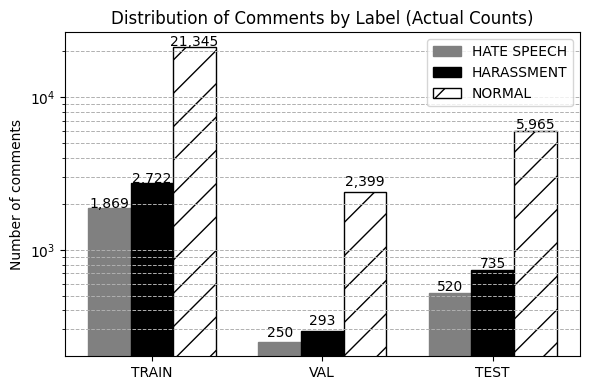

In [ ]:
label_id_to_name = {0: 'NORMAL', 1: 'HATE', 2: 'HARASSMENT'}

train_label_counts = combined_train['label_id'].map(label_id_to_name).value_counts()
val_label_counts = combined_dev['label_id'].map(label_id_to_name).value_counts()
test_label_counts = combined_test['label_id'].map(label_id_to_name).value_counts()

fig, ax = plt.subplots(figsize=(6, 4))

# Heights of the bars
hate_speech_counts = [train_label_counts.get('HATE', 0), val_label_counts.get('HATE', 0), test_label_counts.get('HATE', 0)]
harassment_counts = [train_label_counts.get('HARASSMENT', 0), val_label_counts.get('HARASSMENT', 0), test_label_counts.get('HARASSMENT', 0)]
normal_counts = [train_label_counts.get('NORMAL', 0), val_label_counts.get('NORMAL', 0), test_label_counts.get('NORMAL', 0)]

# The x position of bars
barWidth = 0.25
r1 = np.arange(len(hate_speech_counts))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Plotting the bars
plt.bar(r1, hate_speech_counts, color='grey', width=barWidth, edgecolor='grey', label='HATE SPEECH')
plt.bar(r2, harassment_counts, color='black', width=barWidth, edgecolor='black', label='HARASSMENT')
plt.bar(r3, normal_counts, color='white', width=barWidth, edgecolor='black', hatch='/', label='NORMAL')

# Adding the annotations for counts on top of the bars
def add_labels(x, counts):
    for i in range(len(x)):
        plt.text(x[i], counts[i] + max(counts) * 0.01, f'{counts[i]:,.0f}', ha='center')
add_labels(r1, hate_speech_counts)
add_labels(r2, harassment_counts)
add_labels(r3, normal_counts)

# General layout
plt.xticks([r + barWidth for r in range(len(hate_speech_counts))], ['TRAIN', 'VAL', 'TEST'])
plt.ylabel('Number of comments')
plt.yscale('log')
plt.title('Distribution of Comments by Label (Actual Counts)')
plt.legend()

plt.grid(which='both', axis='y', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()

Biểu đồ cho thấy sự mất cân bằng đáng kể trong tập dữ liệu, với số lượng nhận xét 'normal' vượt xa số lượng nhận xét về 'hate_speech' và 'harassment'.

1. **Mất cân bằng**: Các mô hình có xu hướng thiên về class đa số, có khả năng dẫn đến việc xác định kém các class thiểu số.
2. **Overfitting**: Dữ liệu hạn chế về 'hate_speech' và 'harassment' có thể khiến mô hình overfitting dữ liệu đào tạo, cản trở khả năng khái quát hóa của mô hình.
3. Có thể không có đủ sự đa dạng trong các ví dụ về hate_speech và harassment để nắm bắt được các sắc thái của nội dung đó.
4. **Metric**: Accuracy không phải là số liệu đáng tin cậy do tính mất cân bằng nên sẽ dùng điểm F1 mang lại nhiều thông tin hơn.

In [ ]:
# Vietnamese stopwords list
STOPWORDS = 'vietnamese-stopwords-dash.txt'
with open(DATA_PATH + STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

In [ ]:

# Function to generate word clouds
def generate_word_cloud(text_series, title):
    text = ' '.join(text_series)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)
    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate word clouds for each class
for label in combined_train['label_id'].unique():
    generate_word_cloud(combined_train[combined_train['label_id'] == label]['text'].astype(str), f'Word Cloud for {label_id_to_name[label]} Comments')


NameError: name 'label_id_to_name' is not defined

In [ ]:
combined_train[(combined_train['label_id'] == 1) & (combined_train['text'].str.contains(' m '))].head()

,text,label_id
598,"Thanh Tuyền câm mẹ mồm đi,tốt đb,t bị chúng m ...",1
693,Trời má lại đẹp Lan Tường m biết anh này không...,1
750,Dăm ba con chó tín dụng đen tụi m dám tới nhà ...,1
1276,Bố m đéo sợ ok,1
1648,:))))) nay thi doc quyen :V d' cho tu nhan tha...,1


In [ ]:
vihsd_train[(vihsd_train['label_id'] == 1) & (vihsd_train['free_text'].str.contains(' m '))].head(20)

,free_text,label_id
2115,Nó thích mình nó đã yêu cmm luôn chứ bắt m đợi...,1
4406,PhẠm mạng m lag chứ chậm cc,1
8601,Đông Ca là địt cụ m ngủ đi,1
13409,"cc, t bắn 3 phát rồi đấy, ngon vcl ? m đui à ?",1
14061,Bố m đéo sợ ok,1
14087,Vitamin Nhung cđ m chứ ai nữa 😁😁,1
14931,Cũg chưa biết tin ai đc m ơi =)) đồn như lời,1
15122,Cũng đồng ý vs ad nhưng bạn m từ khi tham gia ...,1
15353,Tụt mẹ m ra cho nhanh đỡ phải mặc,1
15667,Đinhh Thị Hoàii Thuu ngủ mẹ m đi,1


# Modeling

## Preprocessing





1.   Word-segmentating texts into words by the pyvi tool
2.    Removing stopwords
3. Changing all texts into lower cases
4. Removing special characters such as hashtags, urls, and mention tags.






In [ ]:
def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)

    return train_sentences

def remove_special_characters(text):
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    return text

def preprocess(text, tokenized = True, lowercased = True):
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    text = remove_special_characters(text)
    text = emoji.replace_emoji(text,"")
    text = text.lower() if lowercased else text
    return text

def pre_process_features(X, y, tokenized=True, lowercased=True):
    X_processed = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    non_empty_indices = [idx for idx, ele in enumerate(X_processed) if ele]
    X_processed = pd.Series(X_processed)[non_empty_indices].tolist()
    y_processed = y.iloc[non_empty_indices].tolist()
    return X_processed, y_processed


In [ ]:
train_X, train_y = pre_process_features(combined_train['text'], combined_train['label_id'], tokenized=True, lowercased = True)
dev_X, dev_y = pre_process_features(combined_dev['text'], combined_dev['label_id'], tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(combined_test['text'], combined_test['label_id'], tokenized=True, lowercased = True)

Tập train trước và sau khi pre_process

In [ ]:
train_X[:10]

['Mn review gì đó như kiểu phim hay qtqd , các kiểu đi để mình còn hi_vọng 🤔',
 'Cho mình xin đc nhé',
 'Sống chậm thôi các má = ) )',
 'Ai cho em cái link của bộ_tộc mixi gaming với em tìm không thấy : ( (',
 'Haizzz_Nhung thì đáng trách thật nhưng tình_hình như này thì Việt_Nam vẫn có_thể tiếp_nhận thêm bệnh_nhân từ nước_ngoài về ( (',
 'Ma ba rat la xinh xan con noi thiet',
 'Hài ...!!',
 'Thằng ad " phản_động " chỉ giỏi " xuyên_tạc đường nối chính_sách của đãng và nhà lước , bôi_nhọ các anh_hùng nực nượng vũ_trang nhân_dân " .Hết đặt mìn xe_đò thì đặt mìn bưu_điện , ném lựu_đạn vào chợ vào rạp_hát , pháo_kích vào nhà dân vào trường_học ko phải là khủng_bố khủng mẹ gì hết , phải gọi là " đi nàm kách mệnh " mới đúng .',
 'Hóng quá đa : v',
 'Phục_vụ giải_trí cho cả đại_đội múa cột giỏi chịu đòn tốt chuyên mở mini show mừng đảng mừng xuân mừng đất_nước đổi_mới : ) )']

In [ ]:
pd.set_option('max_colwidth',800)

In [ ]:
combined_train.head(10)

,text,label_id
0,"Mn review gì đó như kiểu phim hay qtqd, các kiểu đi để mình còn hi vọng 🤔",0
1,Cho mình xin đc nhé,0
2,Sống chậm thôi các má =)),0
3,Ai cho em cái link của bộ tộc mixi gaming với em tìm không thấy :((,0
4,Haizzz Nhung thì đáng trách thật nhưng tình hình như này thì Việt Nam vẫn có thể tiếp nhận thêm bệnh nhân từ nước ngoài về ((,0
5,Ma ba rat la xinh xan con noi thiet,0
6,Hài ...!!,0
7,"Thằng ad ""phản động"" chỉ giỏi ""xuyên tạc đường nối chính sách của đãng và nhà lước, bôi nhọ các anh hùng nực nượng vũ trang nhân dân"". Hết đặt mìn xe đò thì đặt mìn bưu điện, ném lựu đạn vào chợ vào rạp hát, pháo kích vào nhà dân vào trường học ko phải là khủng bố khủng mẹ gì hết, phải gọi là ""đi nàm kách mệnh"" mới đúng.",2
8,Hóng quá đa :v,0
9,Phục vụ giải trí cho cả đại đội múa cột giỏi chịu đòn tốt chuyên mở mini show mừng đảng mừng xuân mừng đất nước đổi mới:)),0


Fasttext Embedding

In [ ]:
EMBEDDING_FILE = 'cc.vi.300.vec'
embeddings_index = {}
with open(DATA_PATH + EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
vocabulary_size = 10000
embedding_dim = 300

tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)

word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
sequence_length = 100

def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y = to_categorical(y, num_classes=3)
    return X, y

# Make features
train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)

In [ ]:
train_X[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  301, 1754,   87,  139, 9857,   87,    1,
        1239],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    

In [ ]:
train_y[:2]

array([[1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## Text-CNN

In [ ]:
batch_size = 256
epochs = 40
drop = 0.5

filter_sizes = [2,3,5]
num_filters = 32

inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 300)             6449700   ['input_1[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 100, 300, 1)          0         ['embedding[0][0]']           
                                                                                                  
 conv2d (Conv2D)             (None, 99, 1, 32)            19232     ['reshape[0][0]']             
                                                                                              

In [ ]:
MODEL_FILE = 'Text_CNN_model_v1.h5'
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(dev_X, dev_y))
model.save(DATA_PATH + MODEL_FILE)

Epoch 1/40
101/101 [==============================] - 40s 277ms/step - loss: 0.8129 - accuracy: 0.7685 - val_loss: 0.6768 - val_accuracy: 0.8151
Epoch 2/40
101/101 [==============================] - 10s 103ms/step - loss: 0.6158 - accuracy: 0.8236 - val_loss: 0.5659 - val_accuracy: 0.8157
Epoch 3/40
101/101 [==============================] - 9s 86ms/step - loss: 0.5278 - accuracy: 0.8284 - val_loss: 0.5077 - val_accuracy: 0.8191
Epoch 4/40
101/101 [==============================] - 6s 53ms/step - loss: 0.4803 - accuracy: 0.8360 - val_loss: 0.4785 - val_accuracy: 0.8294
Epoch 5/40
101/101 [==============================] - 4s 44ms/step - loss: 0.4468 - accuracy: 0.8441 - val_loss: 0.4568 - val_accuracy: 0.8362
Epoch 6/40
101/101 [==============================] - 4s 41ms/step - loss: 0.4191 - accuracy: 0.8505 - val_loss: 0.4384 - val_accuracy: 0.8420
Epoch 7/40
101/101 [==============================] - 4s 36ms/step - loss: 0.3967 - accuracy: 0.8575 - val_loss: 0.4252 - val_accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(test_y, y_pred)
cf1

array([[5684,   92,  154],
       [ 245,  162,  113],
       [ 340,   51,  344]])

In [ ]:
y_pred[:50]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0])

In [ ]:
f1_scores_per_class = f1_score(test_y, y_pred, average=None)

# In F1 score cho mỗi class
for i, score in enumerate(f1_scores_per_class):
    print(f"F1 Score for class {i}: {score}")

F1 Score for class 0: 0.9318796622673989
F1 Score for class 1: 0.39272727272727276
F1 Score for class 2: 0.5111441307578009


In [ ]:
evaluation = f1_score(test_y, y_pred, average='micro')
evaluation

0.8609603340292276

In [ ]:
f1_score(test_y, y_pred, average='macro')

0.613786100567483

In [ ]:
accuracy_score(test_y, y_pred)

0.8609603340292276

<Axes: >

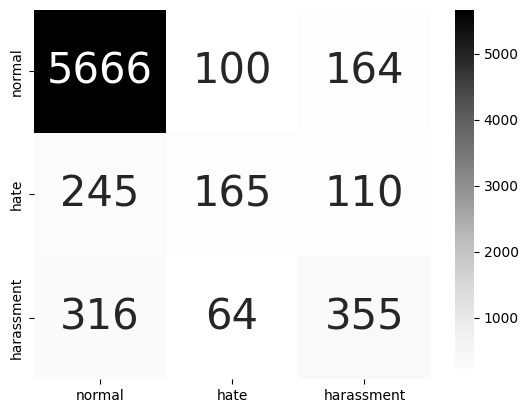

In [ ]:
df_cm1 = pd.DataFrame(cf1, index = ["normal","hate","harassment"],
                  columns = ["normal","hate","harassment"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

In [ ]:
test_X_2k7, test_y_2k7 = pre_process_features(test['text'], test['label'], tokenized=True, lowercased = True)
test_X_2k7, test_y_2k7 = make_featues(test_X_2k7, test_y_2k7, tokenizer, is_one_hot_label=False)

In [ ]:
prediction_2k7 = model.predict(test_X_2k7, batch_size=batch_size, verbose=0)
y_pred_2k7 = prediction_2k7.argmax(axis=-1)

cf2k7 = confusion_matrix(test_y_2k7, y_pred_2k7)

In [ ]:
accuracy_score(test_y_2k7, y_pred_2k7)

0.8277777777777777

In [ ]:
f1_score(test_y_2k7, y_pred_2k7, average='macro')

0.6058923714380131

<Axes: >

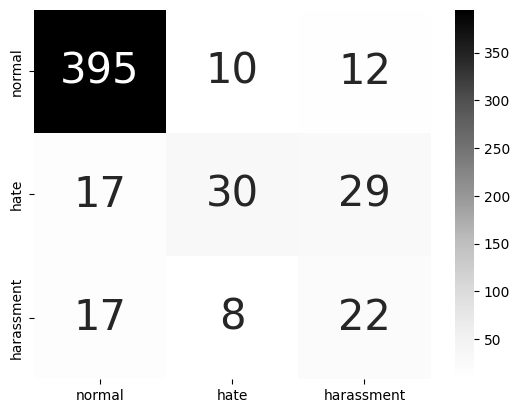

In [ ]:
df_cm2k7 = pd.DataFrame(cf2k7, index = ["normal","hate","harassment"],
                  columns = ["normal","hate","harassment"])
plt.clf()
sn.heatmap(df_cm2k7, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

## GRU

In [ ]:
from keras.layers import Dense, Input, Bidirectional, GRU
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D

In [ ]:
input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(80, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
output = Dense(3, activation="softmax")(conc)

# this creates a model that includes
model = Model(inputs=input, outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 100, 300)             6449700   ['input_2[0][0]']             
                                                                                                  
 spatial_dropout1d (Spatial  (None, 100, 300)             0         ['embedding_1[0][0]']         
 Dropout1D)                                                                                       
                                                                                                  
 bidirectional (Bidirection  (None, 100, 160)             183360    ['spatial_dropout1d[0][0

In [ ]:
batch_size = 256
epochs = 40

MODEL_FILE = 'GRU_model_v1.h5'
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(dev_X, dev_y))
model.save(DATA_PATH + MODEL_FILE)

prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf2 = confusion_matrix(test_y, y_pred)

Epoch 1/40
101/101 [==============================] - 19s 135ms/step - loss: 0.8235 - accuracy: 0.8147 - val_loss: 0.6309 - val_accuracy: 0.8151
Epoch 2/40
101/101 [==============================] - 7s 66ms/step - loss: 0.5864 - accuracy: 0.8224 - val_loss: 0.5851 - val_accuracy: 0.8151
Epoch 3/40
101/101 [==============================] - 7s 67ms/step - loss: 0.5453 - accuracy: 0.8225 - val_loss: 0.5472 - val_accuracy: 0.8151
Epoch 4/40
101/101 [==============================] - 5s 44ms/step - loss: 0.4965 - accuracy: 0.8269 - val_loss: 0.4909 - val_accuracy: 0.8283
Epoch 5/40
101/101 [==============================] - 5s 46ms/step - loss: 0.4357 - accuracy: 0.8472 - val_loss: 0.4456 - val_accuracy: 0.8413
Epoch 6/40
101/101 [==============================] - 4s 36ms/step - loss: 0.3915 - accuracy: 0.8597 - val_loss: 0.4245 - val_accuracy: 0.8443
Epoch 7/40
101/101 [==============================] - 4s 36ms/step - loss: 0.3626 - accuracy: 0.8685 - val_loss: 0.4140 - val_accuracy: 0.84

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
f1_scores_per_class = f1_score(test_y, y_pred, average=None)

# In F1 score cho mỗi class
for i, score in enumerate(f1_scores_per_class):
    print(f"F1 Score for class {i}: {score}")

F1 Score for class 0: 0.9239903001923239
F1 Score for class 1: 0.3820459290187892
F1 Score for class 2: 0.48726772195457674


In [ ]:
accuracy_score(test_y, y_pred)

0.843562978427279

In [ ]:
f1_score(test_y, y_pred, average='micro')

0.843562978427279

In [ ]:
f1_score(test_y, y_pred, average='macro')

0.6013800148529169

<Axes: >

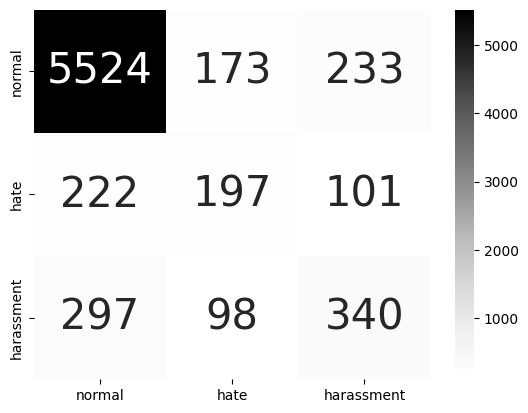

In [ ]:
df_cm2 = pd.DataFrame(cf2, index = ["normal","hate","harassment"],
                  columns = ["normal","hate","harassment"])
plt.clf()
sn.heatmap(df_cm2, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

Danh gia tren tap 2k7

In [ ]:
prediction_2k7 = model.predict(test_X_2k7, batch_size=batch_size, verbose=0)
y_pred_2k7 = prediction_2k7.argmax(axis=-1)

cf2k7 = confusion_matrix(test_y_2k7, y_pred_2k7)

In [ ]:
accuracy_score(test_y_2k7, y_pred_2k7)

0.812962962962963

In [ ]:
f1_score(test_y_2k7, y_pred_2k7, average='macro')

0.590143571417376

<Axes: >

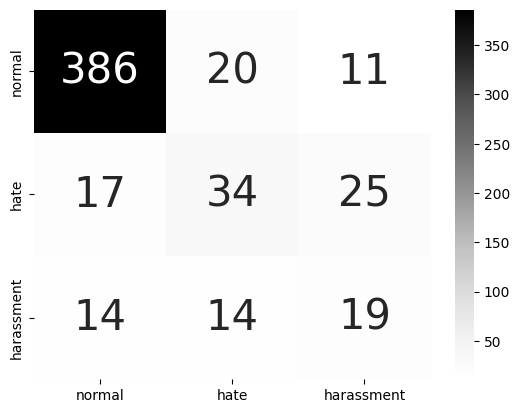

In [ ]:
df_cm2k7 = pd.DataFrame(cf2k7, index = ["normal","hate","harassment"],
                  columns = ["normal","hate","harassment"])
plt.clf()
sn.heatmap(df_cm2k7, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

## PhoBERT

In [ ]:
!pip install vncorenlp

In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2024-04-05 09:45:24--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  91.2MB/s    in 0.3s    

2024-04-05 09:45:25 (91.2 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2024-04-05 09:45:25--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respo

In [ ]:
from vncorenlp import VnCoreNLP

vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [ ]:
def preprocess(text, tokenized = True, lowercased = True):
    # text = filter_stop_words(text, stopwords)
    # text = remove_special_characters(text)
    # text = emoji.replace_emoji(text,"")
    text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        sentences = vncorenlp.tokenize(text)
        for sentence in sentences:
            pre_text += " ".join(sentence)
        text = pre_text
    return text

def pre_process_features(X, y, tokenized=True, lowercased=True):
    X_processed = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    non_empty_indices = [idx for idx, ele in enumerate(X_processed) if ele]
    X_processed = pd.Series(X_processed)[non_empty_indices].tolist()
    y_processed = y.iloc[non_empty_indices].tolist()
    return X_processed, y_processed

In [ ]:
train_X, train_y = pre_process_features(combined_train['text'], combined_train['label_id'], tokenized=True, lowercased = False)
dev_X, dev_y = pre_process_features(combined_dev['text'], combined_dev['label_id'], tokenized=True, lowercased = False)
test_X, test_y = pre_process_features(combined_test['text'], combined_test['label_id'], tokenized=True, lowercased = False)

In [ ]:
test_X_2k7, test_y_2k7 = pre_process_features(test['text'], test['label'], tokenized=True, lowercased = False)

In [ ]:
pip install transformers[torch] accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels = 3)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base",use_fast=False)

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)
test_2k7_encodings = tokenizer(test_X_2k7, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)
test_2k7 = BuildDataset(test_2k7_encodings, test_y_2k7)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir=DATA_PATH + "transformer_model/phobert-v3/",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset
)

trainer.train()
trainer.save_model(DATA_PATH + "/transformer_model/phobert-v3/")

# y_pred_classify = trainer.predict(test_dataset)

# y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
# y_true = test_y

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
500,0.555100
1000,0.434700
1500,0.394900
2000,0.326600
2500,0.289600
3000,0.283300


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(DATA_PATH + "/transformer_model/phobert-v3/")

In [ ]:
training_args = TrainingArguments(
    output_dir=DATA_PATH + "transformer_model/phobert-v3/",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset
)

# Predict on the test dataset
y_pred_classify = trainer.predict(test_dataset)

# Extract predictions
y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
cf1 = confusion_matrix(y_true, y_pred)

In [ ]:
f1_scores_per_class = f1_score(y_true, y_pred, average=None)

# In F1 score cho mỗi class
for i, score in enumerate(f1_scores_per_class):
    print(f"F1 Score for class {i}: {score}")

F1 Score for class 0: 0.9408668476025989
F1 Score for class 1: 0.43394199785177234
F1 Score for class 2: 0.5792592592592593


In [ ]:
accuracy_score(y_true,y_pred)

0.874376731301939

In [ ]:
f1_score(y_true, y_pred, average='micro')

0.874376731301939

In [ ]:
f1_score(y_true, y_pred, average='macro')

0.6513560349045435

<Axes: >

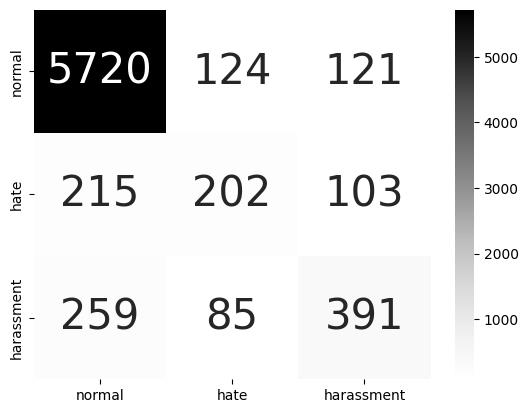

In [ ]:
df_cm1 = pd.DataFrame(cf1, index = ["normal","hate","harassment"],
                  columns = ["normal","hate","harassment"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

In [ ]:
prediction_2k7 = trainer.predict(test_2k7)
y_pred_2k7 = np.argmax(prediction_2k7.predictions, axis=-1)

cf2k7 = confusion_matrix(test_y_2k7, y_pred_2k7)

In [ ]:
accuracy_score(test_y_2k7, y_pred_2k7)

0.8648148148148148

In [ ]:
f1_score(test_y_2k7, y_pred_2k7, average='macro')

0.6791154424281035

<Axes: >

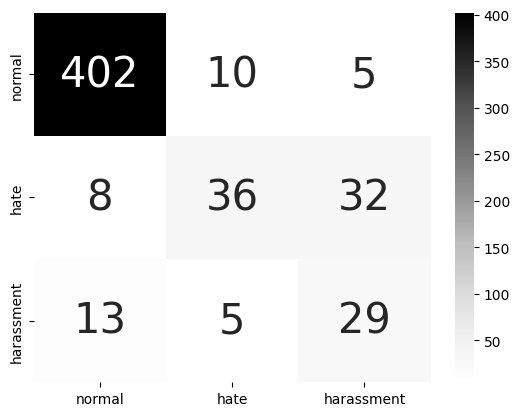

In [ ]:
df_cm2k7 = pd.DataFrame(cf2k7, index = ["normal","hate","harassment"],
                  columns = ["normal","hate","harassment"])
plt.clf()
sn.heatmap(df_cm2k7, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

In [ ]:
misclassified_indices = np.where((np.array(y_true) != 0) & (y_pred == 0))[0]

In [ ]:
len(misclassified_indices)

474

In [ ]:
combined_test.iloc[misclassified_indices].head(20)

,text,label_id
0,từ dịch này thấy ý thức người nhật xăng đổ nửa...,2
14,K có nghìn nào giúp dân thì nín đi!,2
16,Yenie Cao riết mặp như heo r mà cho ăn quài 😭😭😭😭,2
18,Nguyễn Đức Ánh khôn hơn cả họ nhà m.,2
21,Tây nó lại bảo mới trốn viện,1
25,Trùm cuối cmn hú vía :)),1
82,Súc vật từ nhan sắc đến nhân cách súc phạm loà...,2
111,Xem bực mình thêm,1
121,"Cuốn dell nhặt đc mồm, toàn danh hài đất Việt :))",1
138,Chỗ này đit phải chỗ gạ địt nhé hahhahah.,1


In [ ]:
misclassified_indices = np.where((np.array(test_y_2k7) ==1) & (y_pred_2k7 == 2))[0]

In [ ]:
len(misclassified_indices)

32

In [ ]:
pd.set_option('max_colwidth', 800)

In [ ]:
test.iloc[misclassified_indices]

,text,label
1162,"Phạm Thái Hoàng Long ồ loại m đ cãi dc là lại địt mẹ mày à, loạn luân vcl",1
161,Joseph Tuấn Anh T mà ăn hiếp m à thằng lồn,1
1507,Anh Duy lại chó nữa🐶\nCái dm chó cắn chó ăn cứt đi đừng có đi cắn người,1
1920,Khanh Pham Van mày đi hỏi nó đi! Đm ngu lồn tỏ vẻ hiểu biết.,1
1395,Má sử cho đẹp con đĩ đó nha má nghe nó ns mà tức thiệt chứ,1
1211,Hiền Hén thông cảm cho con mụ điên đấy tý đi chị êii,1
2106,Tui xin hỏi tụi con gái thử mày bị đánh trc mặt biết bao người v có biết nhục ko may cho mày là kiếm đc thằng ck bt nhịn mày gặp máy đứa khác đánh cho mày tung lôl,1
2229,Dcm may thang lon chung may ngu vay. Bon cho cong an ko đánh nhung no goi nguòi khac toi đánh. Chúng may song ma éo biet gi chet het đi bon ngu,1
2161,Hùng Sơn thằng đéo bò chữa hoang này.mày biết tao vùng nào không mà vào sủa vậy? Dòng họ tao điều có 1 số người làm việc và theo 2 chế độ.tôn giáo cũng có thiên chúa nghen thằng đầu bò.nhưng khi hòa bình 2 phía vẫn nhìn nhau và giúp đỡ lẫn nhau,1
567,Hồng Thơm hết chia sẻ rồi lại bình luận xàm lồn để lzi để chúng nó thấy rồi cười vào mặt cho à bớt bớt đi địt mẹ k có tiền ms buồn đi buồn vì 3 cái thằng vác buồi đi khắp thế gian lm lồn gì ns mãi vẫn thế đm ngu nó ít thôi cho t nhờ,1
